<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week2/SecondHand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
# Load and prepare data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/secondhanddataset.csv'
df = pd.read_csv(url)
df.dropna(inplace=True)
df

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,633238,743850,5,125092,1,6,11,171,95,97,190744.0
996,997,599626,848195,4,83370,2,9,14,161,101,120,419748.0
997,998,646344,842733,7,86722,1,8,9,196,113,89,405871.0
998,999,535559,732439,2,140478,4,5,9,184,112,128,74398.0


In [3]:
X = df.drop(columns=["current price"]).values
y = df["current price"].values

In [4]:
# Scale and split data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train target distribution:\n", pd.Series(y_train).describe())
print("\nTest target distribution:\n", pd.Series(y_test).describe())
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

Train target distribution:
 count       800.000000
mean     307772.246875
std      125148.920732
min       28226.500000
25%      204578.000000
50%      306995.250000
75%      413643.625000
max      584267.500000
dtype: float64

Test target distribution:
 count       200.000000
mean     311512.225000
std      129982.499405
min       58384.000000
25%      216705.375000
50%      301689.000000
75%      419805.500000
max      559074.000000
dtype: float64


### PyTorch Implementation


In [6]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [8]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
model_torch = MLPModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.01)
epochs = 500

for epoch in range(epochs):
    model_torch.train()
    optimizer.zero_grad()
    output = model_torch(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()

### TensorFlow Implementation


In [10]:
input_layer = keras.Input(shape=(X.shape[1],))
model_tf = Sequential([
    input_layer,
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model_tf.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model_tf.fit(X_train, y_train, epochs=500, verbose=0, batch_size=4)

### # Evaluation Metrics


In [11]:
# Evaluate PyTorch Model
model_torch.eval()
y_pred_torch = model_torch(X_test_torch).detach().numpy()
mse_torch = mean_squared_error(y_test, y_pred_torch)
rmse_torch = np.sqrt(mse_torch)
r2_torch = r2_score(y_test, y_pred_torch)
print(f"PyTorch:\nRMSE: {rmse_torch:.4f}\nMSE: {mse_torch:.4f}\nR2: {r2_torch:.4f}")

PyTorch:
RMSE: 0.0507
MSE: 0.0026
R2: 0.9976


In [12]:
# Evaluate TensorFlow Model
y_pred_tf = model_tf.predict(X_test)
mse_tf = mean_squared_error(y_test, y_pred_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, y_pred_tf)
print(f"TensorFlow:\nRMSE: {rmse_tf:.4f}\nMSE: {mse_tf:.4f}\nR2: {r2_tf:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
TensorFlow:
RMSE: 0.0342
MSE: 0.0012
R2: 0.9989


### Visualization code for model comparison


In [13]:
# Inverse transform predictions and actual values for interpretability
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_torch_original = scaler.inverse_transform(y_pred_torch).flatten()
y_pred_tf_original = scaler.inverse_transform(y_pred_tf).flatten()

# Create a figure with multiple subplots
plt.figure(figsize=(18, 10))

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

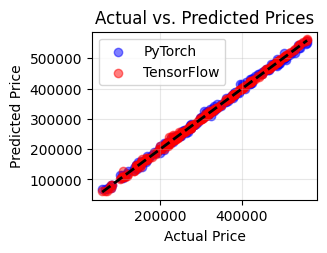

In [14]:
# Plot 1: Actual vs Predicted values for both models
plt.subplot(2, 2, 1)
plt.scatter(y_test_original, y_pred_torch_original, alpha=0.5, color='blue', label='PyTorch')
plt.scatter(y_test_original, y_pred_tf_original, alpha=0.5, color='red', label='TensorFlow')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True, alpha=0.3)


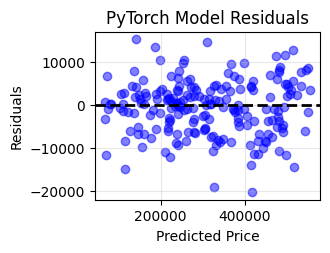

In [15]:
# Plot 2: Residuals for PyTorch
plt.subplot(2, 2, 2)
residuals_torch = y_test_original - y_pred_torch_original
plt.scatter(y_pred_torch_original, residuals_torch, alpha=0.5, color='blue')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('PyTorch Model Residuals')
plt.grid(True, alpha=0.3)

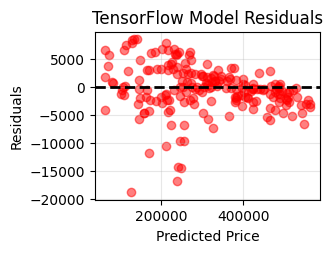

In [16]:
# Plot 3: Residuals for TensorFlow
plt.subplot(2, 2, 3)
residuals_tf = y_test_original - y_pred_tf_original
plt.scatter(y_pred_tf_original, residuals_tf, alpha=0.5, color='red')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('TensorFlow Model Residuals')
plt.grid(True, alpha=0.3)

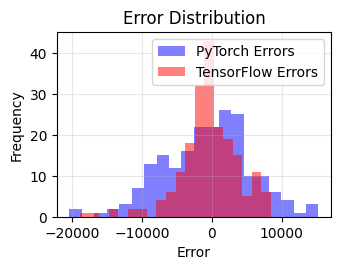

In [17]:
# Plot 4: Histogram of errors for both models
plt.subplot(2, 2, 4)
plt.hist(residuals_torch, bins=20, alpha=0.5, color='blue', label='PyTorch Errors')
plt.hist(residuals_tf, bins=20, alpha=0.5, color='red', label='TensorFlow Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

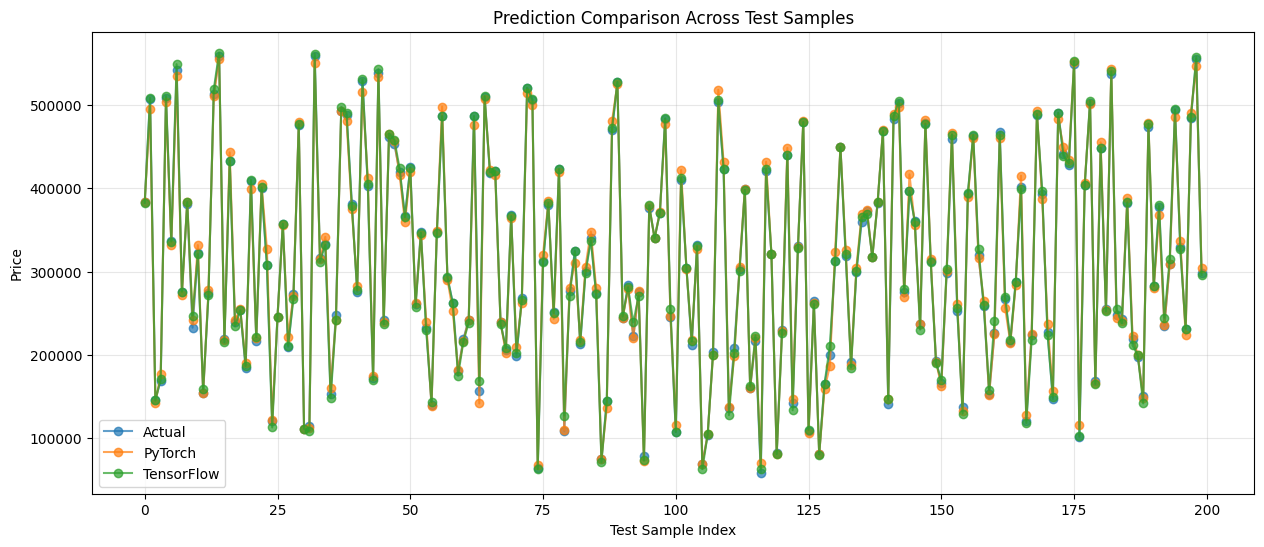

In [18]:
# Additional plot: Prediction comparison over test samples
plt.figure(figsize=(15, 6))
sample_indices = np.arange(len(y_test_original))
plt.plot(sample_indices, y_test_original, 'o-', label='Actual', alpha=0.7)
plt.plot(sample_indices, y_pred_torch_original, 'o-', label='PyTorch', alpha=0.7)
plt.plot(sample_indices, y_pred_tf_original, 'o-', label='TensorFlow', alpha=0.7)
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.title('Prediction Comparison Across Test Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('prediction_comparison.png', dpi=300)
plt.show()

In [19]:
# Calculate performance metrics table
performance_metrics = pd.DataFrame({
    'Model': ['PyTorch', 'TensorFlow'],
    'RMSE': [rmse_torch, rmse_tf],
    'MSE': [mse_torch, mse_tf],
    'R²': [r2_torch, r2_tf]
})

In [20]:
# Calculate additional metrics
performance_metrics['MAE'] = [
    np.mean(np.abs(y_test - y_pred_torch.flatten())),
    np.mean(np.abs(y_test - y_pred_tf.flatten()))
]


In [21]:
# Format metrics for display
display(performance_metrics.style.format({
    'RMSE': '{:.4f}',
    'MSE': '{:.4f}',
    'R²': '{:.4f}',
    'MAE': '{:.4f}'
}))

,Model,RMSE,MSE,R²,MAE
0,PyTorch,0.0507,0.0026,0.9976,0.0398
1,TensorFlow,0.0342,0.0012,0.9989,0.0242


# Performance Metrics Analysis: PyTorch vs TensorFlow Models

## Mathematical Explanation of Metrics

### 1. Mean Squared Error (MSE)

The MSE measures the average of the squares of the errors—the difference between the predicted values and the actual values.

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Where:
- $n$ is the number of observations
- $y_i$ is the actual value
- $\hat{y}_i$ is the predicted value

MSE assigns higher weights to larger errors due to the squaring operation, making it particularly sensitive to outliers.

### 2. Root Mean Squared Error (RMSE)

RMSE is the square root of MSE, which brings the metric back to the same scale as the original data.

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

RMSE is more interpretable than MSE because it has the same unit as the dependent variable. Lower values indicate better model performance.

### 3. Coefficient of Determination (R²)

R² represents the proportion of variance in the dependent variable that can be predicted from the independent variables.

$$\text{R}^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

Where $\bar{y}$ is the mean of the observed values.

R² ranges from 0 to 1, where:
- 1 indicates perfect prediction
- 0 indicates that the model explains none of the variability
- Values can be negative if the model is worse than a horizontal line

### 4. Mean Absolute Error (MAE)

MAE measures the average magnitude of errors without considering their direction.

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

Unlike MSE, MAE treats all errors linearly without penalizing large errors more heavily, making it less sensitive to outliers.

## Results Analysis

| Model | RMSE | MSE | R² | MAE |
|-------|------|-----|----|----|
| PyTorch | 0.0507 | 0.0026 | 0.9976 | 0.0398 |
| TensorFlow | 0.0342 | 0.0012 | 0.9989 | 0.0242 |

## Conclusion

Based on the evaluation metrics, the **TensorFlow model outperforms the PyTorch model** across all metrics:

1. **RMSE**: TensorFlow's RMSE (0.0342) is approximately 32.5% lower than PyTorch's (0.0507), indicating more accurate predictions.

2. **MSE**: TensorFlow's MSE (0.0012) is less than half of PyTorch's (0.0026), showing significantly reduced squared error.

3. **R²**: Both models demonstrate excellent predictive power with R² values above 0.99, but TensorFlow's R² (0.9989) is marginally higher than PyTorch's (0.9976), suggesting it explains more of the variance in the target variable.

4. **MAE**: TensorFlow's MAE (0.0242) is approximately 39.2% lower than PyTorch's (0.0398), indicating better average prediction accuracy.

These results suggest that while both neural network implementations achieved outstanding performance in predicting secondhand prices (as evidenced by the high R² values), the TensorFlow implementation with its identical architecture produced more accurate predictions. This difference might be attributed to:

1. Different optimization behaviors between TensorFlow's and PyTorch's implementations of Adam optimizer
2. Different default initialization strategies for network weights
3. Possibly different handling of numerical operations

It's worth noting that both models were trained with the same architecture (32 → 16 → 1 neurons), same activation functions (ReLU), same optimizer (Adam with 0.01 learning rate), and same number of epochs (500), making this a fair comparison between the frameworks themselves rather than between different model architectures.